# PART B - Classification

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import utils
import random
import collections
import numpy
from sklearn import svm, tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from IPython.core.display import display, HTML

In [2]:
# Load dataset from saved file
DATASET_NAME = 'broad'
dataset = utils.load_from_json('%s.json' % DATASET_NAME)
N = len(dataset[dataset.keys()[0]]) # Number of sounds per class
CLASS_NAMES = dataset.keys()
print 'Loaded dataet "%s" (%i classes, %i sounds per class)' % (DATASET_NAME, len(dataset.keys()), N)

Loaded dataet "broad" (3 classes, 100 sounds per class)


In [3]:
# Set configuration parameters (to be used below)
NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 10 # Maximum number of dimensions for the feature vector.
CLASSIFIER_TYPE = 'tree' # Use 'svm' or 'tree'
PERCENTAGE_OF_TRAINING_DATA = 0.5 # Percentage of sounds that will be used for training (others are for testing)
MAX_INPUT_TAGS_FOR_TESTING = 50 # Use a big number to "omit" this parameter and use as many tags as originally are in the sound

### 3) Define vector space

In [4]:
def build_tag_vector_space(n_dimensions, dataset, class_names): 
    # Get all tags in the dataset (the vocabulary)
    all_tags = list()
    for class_name in class_names:
        class_tags = utils.get_all_tags_from_class(class_name, dataset)
        all_tags += class_tags
        
    # Filter out tags with less frequency (get only top N tags)
    most_common_tags = [tag for tag, count in collections.Counter(all_tags).most_common(n_dimensions)]
    filtered_tags = [tag for tag in most_common_tags if tag in all_tags]
    
    # Build our prototype feature vector (unique list of tags), and print first 10 tags
    prototype_feature_vector = list(set(filtered_tags))
    print 'Created prototype feature vector with %i dimensions (originally %i dimensions)' % (
        len(prototype_feature_vector), len(set(all_tags)))
    print 'Prototype vector tags (sorted by occurrence in filtered_tags):', ', '.join([tag for tag in filtered_tags[:10]]),
    print '...\n' if len(filtered_tags) > 10 else '\n'
    return prototype_feature_vector

prototype_feature_vector = build_tag_vector_space(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
    dataset=dataset,
    class_names=CLASS_NAMES,
)

Created prototype feature vector with 10 dimensions (originally 779 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags): guitar, electric, acoustic, distorted, chord, distortion, Guitar, rock, loop, riff 



### 4) Project documents in the vector space

In [5]:
# Example of getting feature vector from tags list...
random_sound = random.choice(dataset[random.choice(dataset.keys())])
random_sound_tags = random_sound['tags']
random_sound_feature_vector = utils.get_feature_vector_from_tags(random_sound_tags, prototype_feature_vector)

display(HTML(utils.get_sound_embed_html(random_sound['id'])))
print 'Chosen sound has tags:', ', '.join(random_sound_tags)
html = '<table><tr><td>'
html += '</td><td>'.join([tag for tag in prototype_feature_vector])
html += '</td></tr><tr><td>'
html += '</td><td>'.join(['x' if prototype_feature_vector[count] in random_sound_tags else '' 
                          for count, item in enumerate(random_sound_feature_vector)])
html += '</td></tr></table>'
display(HTML(html))

Chosen sound has tags: nylon, string, Guitar, acoustic, micd, strumming


Guitar,chord,electric,rock,distortion,guitar,riff,distorted,acoustic,loop
x,,,,,,,,x,


### 5) Define train and testing set

In [6]:
def create_train_and_test_sets(dataset, class_names, n_sounds_per_class, percentage_training_data, 
                               max_input_tags_for_testing):
    
    n_training_sounds_per_class = int(n_sounds_per_class * percentage_training_data)
    training_set = dict()
    testing_set = dict()

    # Get 'n_training_sounds_per_class' sounds per class 
    for class_name, sounds in dataset.items():
        sounds_from_class = sounds[:] # Copy the list so when we later shuffle it does not affect the original data 
        #random.shuffle(sounds_from_class)
        training_set[class_name] = sounds_from_class[:n_training_sounds_per_class] # First sounds for training
        testing_set[class_name] = sounds_from_class[n_training_sounds_per_class:] # Following sounds for testing
     
        # Save a trimmed version of input tags for testing sounds
        for sound in testing_set[class_name]:
            sound['tags'] = random.sample(sound['tags'], min(max_input_tags_for_testing, len(sound['tags'])))

    print 'Created training and testing sets with the following number of sounds:\n\tTrain\tTest'
    for class_name in class_names:
        training_sounds = training_set[class_name]
        testing_sounds = testing_set[class_name]
        print '\t%i\t%i\t%s' % (len(training_sounds), len(testing_sounds), class_name)
    return training_set, testing_set

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset, 
    class_names=CLASS_NAMES,
    n_sounds_per_class=N,
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA,
    max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING,
)

Created training and testing sets with the following number of sounds:
	Train	Test
	50	50	Distorted Guitar
	50	50	Electric Guitar
	50	50	Acoustic Guitar


### 6) Train classifier

In [7]:
def build_tag_feature_vector(sound):
    tag_features = utils.get_feature_vector_from_tags(sound['tags'], prototype_feature_vector)
    return np.concatenate([[], tag_features])

def train_classifier(training_set, classifier_type, class_names, dataset_name, feature_vector_func, 
                     feature_vector_dimension_labels=None):
    
    # Prepare data for fitting classifier (as sklearn classifiers require)
    classes_vector = list()
    feature_vectors = list()
    for class_name, sounds in training_set.items():
        for count, sound in enumerate(sounds):
            # Use index of class name in CLASS_NAMES as numerical value (classifier internally represents 
            # class label as number)
            classes_vector.append(CLASS_NAMES.index(class_name))
            feature_vector = feature_vector_func(sound)
            feature_vectors.append(feature_vector)

    # Create and fit classifier
    print 'Training classifier (%s) with %i sounds...' % (CLASSIFIER_TYPE, len(feature_vectors)),
    if classifier_type == 'svm':
        classifier = svm.LinearSVC()
        classifier.fit(feature_vectors, classes_vector)
    elif classifier_type == 'tree':
        classifier = tree.DecisionTreeClassifier(max_depth=5)
        classifier.fit(feature_vectors, classes_vector)
        # Plot classifier decision rules
        # WARNING: do not run this if tree is too big, might freeze
        out_filename = '%s_tree.png' % dataset_name
        utils.export_tree_as_graph(
            classifier, feature_vector_dimension_labels, class_names=class_names, filename=out_filename)
        display(HTML('<h4>Learned tree:</h4><img src="%s"/>' % out_filename))
    else:
        raise Exception('Bad classifier type!!!')
    return classifier
        
classifier = train_classifier(
    training_set=training_set,
    classifier_type=CLASSIFIER_TYPE, 
    class_names=CLASS_NAMES, 
    dataset_name=DATASET_NAME,
    feature_vector_func=build_tag_feature_vector,
    feature_vector_dimension_labels=prototype_feature_vector,
)

Training classifier (tree) with 150 sounds...

### 7) Evaluate classification


Evaluating with 150 instances... done!
127 correct predictions
23 wrong predictions
Overall accuracy 84.67%
Confussion matrix


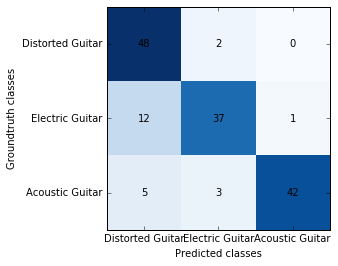

0.8466666666666667

In [8]:
def evaluate_classifier(testing_set, classifier, class_names, feature_vector_func, show_confussing_matrix=True):
    # Test with testing set
    print '\nEvaluating with %i instances...' % sum([len(sounds) for sounds in testing_set.values()]),
    predicted_data = list()
    for class_name, sounds in testing_set.items():
        for count, sound in enumerate(sounds):
            feature_vector = feature_vector_func(sound)
            predicted_class_name = unicode(class_names[classifier.predict([feature_vector])[0]])
            predicted_data.append((sound['id'], class_name, predicted_class_name))     
    print 'done!'

    # Compute overall accuracy
    good_predictions = len([1 for sid, cname, pname in predicted_data if cname == pname])
    wrong_predictions = len([1 for sid, cname, pname in predicted_data if cname != pname])
    print '%i correct predictions' % good_predictions
    print '%i wrong predictions' % wrong_predictions
    accuracy = float(good_predictions)/(good_predictions + wrong_predictions)
    print 'Overall accuracy %.2f%%' % (100 * accuracy)
    
    if show_confussing_matrix:
        # Compute confussion matrix (further analysis)
        matrix = list()
        for class_name in CLASS_NAMES:
            predicted_classes = list()
            for sid, cname, pname in predicted_data:
                if cname == class_name:
                    predicted_classes.append(pname)
            matrix.append([predicted_classes.count(target_class) for target_class in CLASS_NAMES])

        # Plot confussion matrix
        fig = plt.figure()
        plt.clf()
        ax = fig.add_subplot(111)
        ax.set_aspect(1)
        res = ax.imshow(matrix, cmap=plt.cm.Blues, interpolation='nearest')

        for x in xrange(len(matrix)):
            for y in xrange(len(matrix)):
                ax.annotate(str(matrix[x][y]), xy=(y, x), 
                            horizontalalignment='center',
                            verticalalignment='center')

        plt.xticks(range(len(class_names)), class_names)
        plt.yticks(range(len(class_names)), class_names)
        plt.xlabel('Predicted classes')
        plt.ylabel('Groundtruth classes')

        print 'Confussion matrix'
        plt.show()
    
    return accuracy
    
evaluate_classifier(
    testing_set=testing_set,
    classifier=classifier,
    class_names=CLASS_NAMES,
    feature_vector_func=build_tag_feature_vector,
)

Created prototype feature vector with 10 dimensions (originally 779 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags): guitar, electric, acoustic, distorted, chord, distortion, Guitar, rock, loop, riff 

Created training and testing sets with the following number of sounds:
	Train	Test
	75	25	Distorted Guitar
	75	25	Electric Guitar
	75	25	Acoustic Guitar
Training classifier (tree) with 225 sounds... 
Evaluating with 75 instances... done!
37 correct predictions
38 wrong predictions
Overall accuracy 49.33%
Confussion matrix


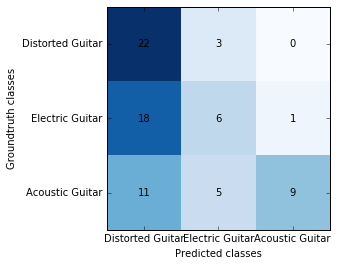

Created prototype feature vector with 10 dimensions (originally 688 dimensions)
Prototype vector tags (sorted by occurrence in filtered_tags): guitar, electric, acoustic, distorted, chord, Guitar, distortion, rock, loop, riff 

Created training and testing sets with the following number of sounds:
	Train	Test
	75	25	Distorted Guitar
	75	25	Electric Guitar
	75	25	Acoustic Guitar
Training classifier (tree) with 225 sounds...

 
Evaluating with 75 instances... done!
38 correct predictions
37 wrong predictions
Overall accuracy 50.67%
Confussion matrix


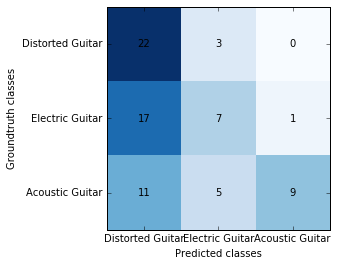

In [9]:
# Run the whole experiment again with other parameters

NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 10
PERCENTAGE_OF_TRAINING_DATA = 0.75
MAX_INPUT_TAGS_FOR_TESTING = 2

for classifier_type in ['svm', 'tree']:  
    display(HTML('<h2>With %s classifier</h2>' % classifier_type.upper()))

    prototype_feature_vector = build_tag_vector_space(
        n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR,
        dataset=dataset,
        class_names=CLASS_NAMES,
    )
    training_set, testing_set = create_train_and_test_sets(
        dataset=dataset, 
        class_names=CLASS_NAMES,
        n_sounds_per_class=N,
        percentage_training_data=PERCENTAGE_OF_TRAINING_DATA,
        max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING,   
    )
    classifier = train_classifier(
        training_set=training_set,
        classifier_type=classifier_type, 
        class_names=CLASS_NAMES, 
        dataset_name=DATASET_NAME,
        feature_vector_func=build_tag_feature_vector,
        feature_vector_dimension_labels=prototype_feature_vector,
    )
    evaluate_classifier(
        testing_set=testing_set,
        classifier=classifier,
        class_names=CLASS_NAMES,
        feature_vector_func=build_tag_feature_vector,
    )

In [10]:
# CODE FOR GENERATING FEATURE VECTORS WITH LATENT SEMANTIC ANALYSIS

def build_latent_semantic_analysis_feature_vectors(n_dimensions, training_set, testing_set):
    # Build latent semantic analysis (LSA) matrix factors
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, stop_words='english', analyzer='word', max_features=50000)
    svd = TruncatedSVD(n_components=n_dimensions, n_iter=7, random_state=42)

    # Compute LSA feature vectors for training set
    lsa_feature_vectors = list()
    lsa_feature_vectors_sound_ids = list()
    for class_name, sounds in training_set.items():
        for sound in sounds:
            lsa_feature_vectors.append(' '.join(sound['tags']))
            lsa_feature_vectors_sound_ids.append(sound['id'])
    X = vectorizer.fit_transform(lsa_feature_vectors)
    lsa_feature_vectors = svd.fit_transform(X)
    lsa_feature_vectors_dict = {sound_id:features for sound_id, features 
                                in zip(lsa_feature_vectors_sound_ids, lsa_feature_vectors)}

    # Now compute LSA feature vectors for testing set (using vectorizer and svd learnt for training set)
    lsa_feature_vectors = list()
    lsa_feature_vectors_sound_ids = list()
    for class_name, sounds in testing_set.items():
        for sound in sounds:
            lsa_feature_vectors.append(' '.join(sound['tags']))
            lsa_feature_vectors_sound_ids.append(sound['id'])
    X = vectorizer.transform(lsa_feature_vectors)
    lsa_feature_vectors = svd.transform(X)
    lsa_feature_vectors_dict.update({sound_id:features for sound_id, features 
                                     in zip(lsa_feature_vectors_sound_ids, lsa_feature_vectors)})

    print 'Built LSA feature vectors for %i sounds!' % len(lsa_feature_vectors_dict)
    return lsa_feature_vectors_dict

Built LSA feature vectors for 291 sounds!
Created training and testing sets with the following number of sounds:
	Train	Test
	75	25	Distorted Guitar
	75	25	Electric Guitar
	75	25	Acoustic Guitar
Training classifier (tree) with 225 sounds...

 
Evaluating with 75 instances... done!
47 correct predictions
28 wrong predictions
Overall accuracy 62.67%
Confussion matrix


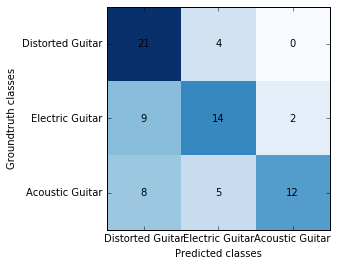

0.6266666666666667

In [11]:
# EXAMPLE EXPERIMENT USING LATENT SEMANTIC ANALYSIS

display(HTML('<h2>With Latent Semantic Analysis</h2>'))

NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR = 10
CLASSIFIER_TYPE = 'tree'
PERCENTAGE_OF_TRAINING_DATA = 0.75
MAX_INPUT_TAGS_FOR_TESTING = 2

def build_lsa_feature_vector(sound):
    lsa_features = lsa_feature_vectors_dict[sound['id']]
    return np.concatenate([[], lsa_features])

lsa_feature_vectors_dict = build_latent_semantic_analysis_feature_vectors(
    n_dimensions=NUMBER_OF_DIMENSIONS_OF_FEATURE_VECTOR, training_set=training_set, testing_set=testing_set,)

training_set, testing_set = create_train_and_test_sets(
    dataset=dataset, class_names=CLASS_NAMES, n_sounds_per_class=N, 
    percentage_training_data=PERCENTAGE_OF_TRAINING_DATA, max_input_tags_for_testing=MAX_INPUT_TAGS_FOR_TESTING)
classifier = train_classifier(
    training_set=training_set, classifier_type=CLASSIFIER_TYPE, class_names=CLASS_NAMES, dataset_name=DATASET_NAME,
    feature_vector_func=build_lsa_feature_vector,
)
evaluate_classifier(
    testing_set=testing_set, classifier=classifier, class_names=CLASS_NAMES, 
    feature_vector_func=build_lsa_feature_vector)